---

ITBA - Ingeniería Electrónica

25.87 - Redes Neuronales II - Computer Vision

---

**TP3 - TGS - Nov. 2024**

Grupo: 
* HEIR, Alejandro Nahuel - 62496
* SBRUZZI, Juan Francisco - 62517

---

Challenge: [TGS Salt Identification Challenge](https://www.kaggle.com/competitions/tgs-salt-identification-challenge)

---

Referencias: 
* Estructura principal: [U-net, dropout, augmentation, stratification](https://www.kaggle.com/code/phoenigs/u-net-dropout-augmentation-stratification)
* Custom metric:
    * [Explanation of Scoring Metric](https://www.kaggle.com/code/pestipeti/explanation-of-scoring-metric)
    * [Creating custom metrics](https://keras.io/api/metrics/#creating-custom-metrics)
* [Augmentation that works](https://www.kaggle.com/competitions/tgs-salt-identification-challenge/discussion/63974)
* [Improving from 0.78 to 0.84+](https://www.kaggle.com/competitions/tgs-salt-identification-challenge/discussion/65226)
* [Hypercolumns for Object Segmentation and Fine-grained Localization](https://openaccess.thecvf.com/content_cvpr_2015/papers/Hariharan_Hypercolumns_for_Object_2015_CVPR_paper.pdf)

---

¿Qué se hizo?
1. Partiendo de la notebook de referencia, agregando a la U-Net acticaciones LeakyRelu, BN y Dropout, se logró un public score (PS) de 0.74378
2. Sobre eso, se cambió la loss a BinaryFocalCrossEntropy, dando PS=0.72591. *It helps to apply a "focal factor" to down-weight easy examples and focus more on hard examples.*
3. Se exploró la implementación de *hypercolumns* sobre la red, no dando mejoras.
4. Se amplió la augmentación original, que solo contenía una iteración de flips horizontales, agregando más transformaciones y realizando 4 iteraciones, ampliando el train 16k imágenes.
5. Se implementó la métrica IoU propuesta en el challenge para incluir en el pipeline de entrenamiento.
6. Con los dos agregados anteriores, y BinaryCrossEntropy, se obtuvo PS=0.70571
7. Se decide entrenar con 8 combinacinoes de hiperparámetros (loss, metric, optimizer) para hallar las más óptima.
    * Con la mejor métrica bajo accuracy: PS=
    * Con la mejor métrica bajo custom_iou: PS=

---

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import ops
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Lambda

import albumentations as A
!pip install -U albumentations --quiet

from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# EDA

Se realiza la carga y exploración de los datos disponibles.

In [47]:
train_df = pd.read_csv("/kaggle/input/tgs-salt-identification-challenge/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("/kaggle/input/tgs-salt-identification-challenge/depths.csv", index_col='id')

In [48]:
print(train_df.shape, depths_df.shape)

(4000, 0) (22000, 1)


In [49]:
train_df

Empty DataFrame
Columns: []
Index: [575d24d81d, a266a2a9df, 75efad62c1, 34e51dba6a, 4875705fb0, 782ae9b7e7, 9842f69f8d, aa94cfb806, 50d3073821, 28f865caaa, b5e1371b3b, 57e394bc67, b45ad3932e, ef51bbcde7, d4d34af4f7, 302ea1ac81, 40dcff68b3, 7845115d01, 3da729cae9, d67e3a11d8, b3396387a6, a5471f53d8, d27831fef2, 7faea04242, 9747413253, b9614348f4, 4696bb53e6, fc250f574c, 005b452274, 02117a400e, 4e4cadf03f, 1ee0d5b4d0, fdc28cafdc, 2bc8a3db3c, 35fd991255, 68a2df3195, 3be0c0be8e, 1f0b16aa13, 9bf982cf65, 36aa21019e, d422a9eb8f, e0b6a1211f, 5e3c2aa2bb, d3f3db7bd1, 0b176124c4, 368f635c4c, eabe9337a9, c4f2799234, 50290e75f9, 06289f69f8, 3f8634704b, f328eccbf3, 9f0ebbd210, dd5a90cf89, 5b836d2444, 6c3a9009c8, 1263576548, 5edb37f5a8, 3f8a8f4715, 75e041fbd8, 58777a8c79, b2899a1188, 428a877104, 13209940d7, d0319f0ec5, b92ff69b44, 9e9f3940a9, 728890d8f8, 754cfc4b80, 127ef4105f, 42758bb41a, 4e6855dbae, 4a12baccc4, 3281bb7282, f1774ff8e8, 628ea36ba6, 95a60e2f42, e2421eee13, fcb49356a5, 63feb8de2b, 992572448c, 0926b7396b, 8f407b64ae, e667f4d290, 7deaf30c4a, 28553d5d42, be565e046b, b183b2ddc4, cf11876547, 495a2d3c7c, a536f382ec, 8fb68e99e8, a8247ac73a, 9f3b8d0186, 05be75afd9, e4159ed1de, 3ed6d1c7df, 7977cbab6f, b221ece24b, 29d8bf3a4c, ...]

[4000 rows x 0 columns]

In [50]:
depths_df

z
id             
4ac19fb269  306
1825fadf99  157
f59821d067  305
5b435fad9d  503
e340e7bfca  783
...         ...
09f1675cfb  400
6947dbc4f4  804
68de95fb39  605
fdad2f99d8  309
d7c57f676e  532

[22000 rows x 1 columns]

In [51]:
depths_df['z']

id
4ac19fb269    306
1825fadf99    157
f59821d067    305
5b435fad9d    503
e340e7bfca    783
             ... 
09f1675cfb    400
6947dbc4f4    804
68de95fb39    605
fdad2f99d8    309
d7c57f676e    532
Name: z, Length: 22000, dtype: int64

In [52]:
train_df = train_df.join(depths_df) # agrega depths a cada id de train
train_df

z
id             
575d24d81d  843
a266a2a9df  794
75efad62c1  468
34e51dba6a  727
4875705fb0  797
...         ...
9cbd5ddba4  218
caa039b231  602
1306fcee4c  177
48d81e93d9  221
edf1e6ac00  460

[4000 rows x 1 columns]

In [53]:
test_df = depths_df[~depths_df.index.isin(train_df.index)] # test como los depths que no son train
test_df

z
id             
353e010b7b  264
5439dbbddf  557
71bab9f311  846
52551f7a80  610
512d8d9997  577
...         ...
09f1675cfb  400
6947dbc4f4  804
68de95fb39  605
fdad2f99d8  309
d7c57f676e  532

[18000 rows x 1 columns]

In [54]:
!unzip -o -q -u "/kaggle/input/tgs-salt-identification-challenge/train.zip" -d "/kaggle/working/train/"
!unzip -o -q -u "/kaggle/input/tgs-salt-identification-challenge/test.zip" -d "/kaggle/working/test/"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [55]:
!tree -d

.
|-- test
|   `-- images
`-- train
    |-- images
    `-- masks

5 directories


In [56]:
!ls -1 /kaggle/working/test/images/ | wc -l
!ls -1 /kaggle/working/train/images/ | wc -l
!ls -1 /kaggle/working/train/masks/ | wc -l

18000
4000
4000


In [57]:
# se agregan las imágenes al train_df, normalizadas y BW
train_df['images'] = [np.array(load_img("/kaggle/working/train/images/{}.png".format(idx), color_mode='grayscale')) / 255 for idx in tqdm(train_df.index)]

100%|██████████| 4000/4000 [00:02<00:00, 1926.69it/s]


In [58]:
# se agregan las masks al train_df
train_df['masks'] = [np.array(load_img("/kaggle/working/train/masks/{}.png".format(idx), color_mode='grayscale')) for idx in tqdm(train_df.index)]
train_df['masks'] = train_df['masks'].apply(lambda x: (x > 0).astype(np.uint8))

100%|██████████| 4000/4000 [00:00<00:00, 6811.26it/s]


In [59]:
train_df.head(50)

z                                             images  \
id                                                                   
575d24d81d  843  [[0.5254901960784314, 0.5137254901960784, 0.52...   
a266a2a9df  794  [[0.3411764705882353, 0.3764705882352941, 0.33...   
75efad62c1  468  [[0.5686274509803921, 0.4666666666666667, 0.32...   
34e51dba6a  727  [[0.5411764705882353, 0.4745098039215686, 0.39...   
4875705fb0  797  [[0.06666666666666667, 0.0784313725490196, 0.0...   
782ae9b7e7  677  [[0.6078431372549019, 0.6196078431372549, 0.61...   
9842f69f8d  907  [[0.4392156862745098, 0.4117647058823529, 0.4,...   
aa94cfb806  754  [[0.5058823529411764, 0.49019607843137253, 0.4...   
50d3073821  810  [[0.4666666666666667, 0.5333333333333333, 0.41...   
28f865caaa  147  [[0.43137254901960786, 0.4392156862745098, 0.4...   
b5e1371b3b  325  [[0.4117647058823529, 0.4196078431372549, 0.43...   
57e394bc67  765  [[0.4, 0.396078431372549, 0.4, 0.4431372549019...   
b45ad3932e  613  [[0.43137254901960786, 0.4117647058823529, 0.4...   
ef51bbcde7  712  [[0.4, 0.396078431372549, 0.38823529411764707,...   
d4d34af4f7  114  [[0.3607843137254902, 0.3843137254901961, 0.42...   
302ea1ac81  470  [[0.18823529411764706, 0.1843137254901961, 0.1...   
40dcff68b3  707  [[0.44313725490196076, 0.4235294117647059, 0.3...   
7845115d01  343  [[0.4, 0.4117647058823529, 0.42745098039215684...   
3da729cae9  707  [[0.6823529411764706, 0.6745098039215687, 0.65...   
d67e3a11d8  585  [[0.5176470588235295, 0.5725490196078431, 0.50...   
b3396387a6  407  [[0.4117647058823529, 0.3803921568627451, 0.35...   
a5471f53d8  659  [[0.3803921568627451, 0.403921568627451, 0.407...   
d27831fef2  657  [[0.34901960784313724, 0.34901960784313724, 0....   
7faea04242  818  [[0.45098039215686275, 0.4549019607843137, 0.4...   
9747413253  472  [[0.5215686274509804, 0.4980392156862745, 0.51...   
b9614348f4  429  [[0.3686274509803922, 0.37254901960784315, 0.3...   
4696bb53e6  438  [[0.5019607843137255, 0.5176470588235295, 0.46...   
fc250f574c  684  [[0.9215686274509803, 0.9294117647058824, 0.93...   
005b452274  657  [[0.00392156862745098, 0.0, 0.0156862745098039...   
02117a400e  696  [[0.5411764705882353, 0.4745098039215686, 0.41...   
4e4cadf03f  703  [[0.5725490196078431, 0.5764705882352941, 0.54...   
1ee0d5b4d0  307  [[0.5294117647058824, 0.5607843137254902, 0.53...   
fdc28cafdc  338  [[0.34509803921568627, 0.3333333333333333, 0.3...   
2bc8a3db3c  353  [[0.3764705882352941, 0.403921568627451, 0.423...   
35fd991255  333  [[0.44313725490196076, 0.43137254901960786, 0....   
68a2df3195  555  [[0.42745098039215684, 0.4, 0.3725490196078431...   
3be0c0be8e  797  [[0.40784313725490196, 0.45098039215686275, 0....   
1f0b16aa13  364  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9bf982cf65  716  [[0.596078431372549, 0.6039215686274509, 0.607...   
36aa21019e  482  [[0.2549019607843137, 0.2549019607843137, 0.27...   
d422a9eb8f  662  [[0.403921568627451, 0.4196078431372549, 0.435...   
e0b6a1211f  193  [[0.24705882352941178, 0.24705882352941178, 0....   
5e3c2aa2bb  307  [[0.3333333333333333, 0.3333333333333333, 0.33...   
d3f3db7bd1  258  [[0.34509803921568627, 0.34509803921568627, 0....   
0b176124c4  744  [[0.5882352941176471, 0.5607843137254902, 0.55...   
368f635c4c  698  [[0.34901960784313724, 0.4627450980392157, 0.4...   
eabe9337a9  540  [[0.4666666666666667, 0.4549019607843137, 0.44...   
c4f2799234  188  [[0.47058823529411764, 0.4823529411764706, 0.4...   
50290e75f9  658  [[0.38823529411764707, 0.3803921568627451, 0.3...   
06289f69f8  644  [[0.5450980392156862, 0.5490196078431373, 0.55...   

                                                        masks  
id                                                             
575d24d81d  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
a266a2a9df  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
75efad62c1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
34e51dba6a  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Las masks son las anotaciones de cada pixel de las imagenes:
* 1: sal
* 0: sedimento

Algunas imágenes de train junto a sus masks (anotaciones):

Para id=7c6f76a267, z=369


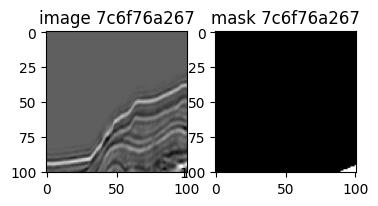


Para id=eeef52be31, z=785


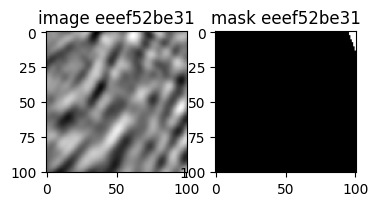


Para id=4a5595076f, z=531


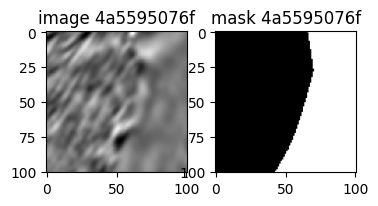


Para id=0977568b54, z=195


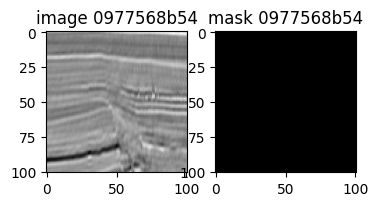


Para id=38232d1fe3, z=399


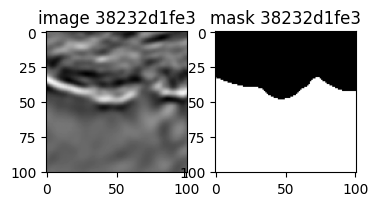


Para id=5a6f57c150, z=210


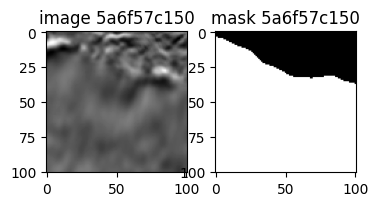

In [60]:
for i in range(1, 7):
    refid = train_df.sample(1).index[0] # id random del train_df
    print(f"Para id={refid}, z={train_df['z'][refid]}")

    fig, ax = plt.subplots(1, 2, figsize=(4, 4))

    ax[0].imshow(train_df['images'][refid], cmap='gray')
    ax[0].set_title(f"image {refid}")

    ax[1].imshow(train_df['masks'][refid], cmap='gray')
    ax[1].set_title(f"mask {refid}")
    plt.show()
    print()

El entrenamiento/clasificación se hará sobre imágenes de 128x128, por lo que se definen funciones de upsampling para normalizar las imágenes antes de pasarlas por la red, y downsampling para luego deshacer los efectos y dar con el score correcto que se pide.

In [61]:
img_size_ori = 101 # 101x101
img_size_target = 128 # 128x128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

## Salt coverage classification

Se aplica una estratificación en función de la cobertura de sal en cada imagen, en 10 clases.

In [62]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df.coverage = train_df.coverage / np.max(train_df.coverage) 

min_cov = np.floor(np.min(train_df.coverage)).astype(np.float64)
max_cov = np.ceil(np.max(train_df.coverage)).astype(np.float64)

min_cov, max_cov

(0.0, 1.0)

In [63]:
def cov_to_class(val, num_classes=11):    
#     if val < min_cov or val > max_cov:
#         raise ValueError(f"Coverage value ({val}) is outside the expected range ({min_cov} - {max_cov})")

#     normalized_cov = (val - min_cov) / (max_cov - min_cov)

#     class_index = int(np.floor(normalized_cov * num_classes))
#     return class_index
    for i in range(0, num_classes):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5, 0, 'Coverage class')

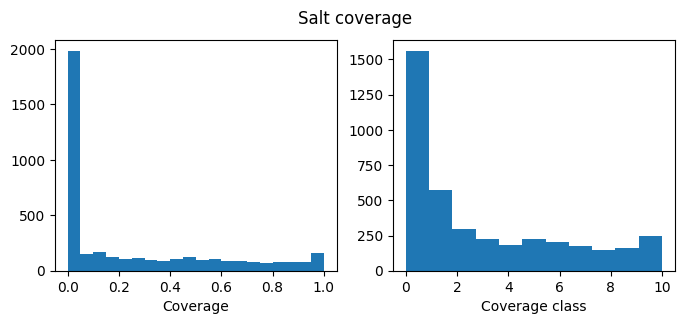

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
plt.suptitle("Salt coverage")
axs[0].hist(train_df.coverage, bins=20)
axs[0].set_xlabel("Coverage")
axs[1].hist(train_df.coverage_class, bins=11)
axs[1].set_xlabel("Coverage class")

Text(0, 0.5, 'Coverage class')

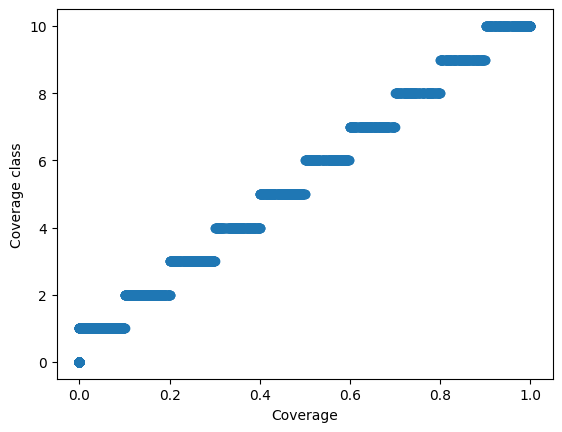

In [65]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

## Depth distributions

Text(0.5, 1.0, 'Depth distribution')

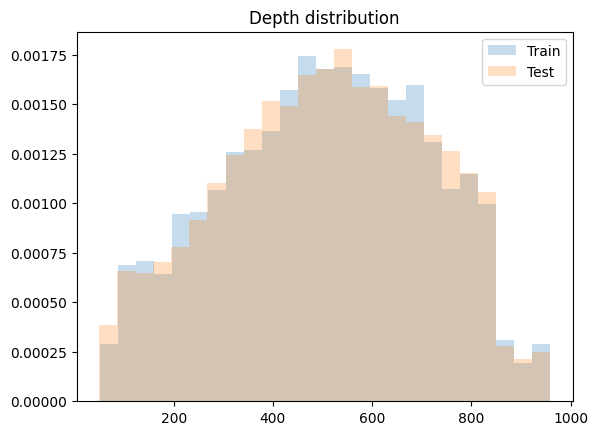

In [66]:
plt.hist(train_df.z, label="Train", alpha=0.25, density=True, bins=25)
plt.hist(test_df.z, label="Test", alpha=0.25, density=True, bins=25)
plt.legend()
plt.title("Depth distribution")

## Some example images

Text(0.5, 0.98, 'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

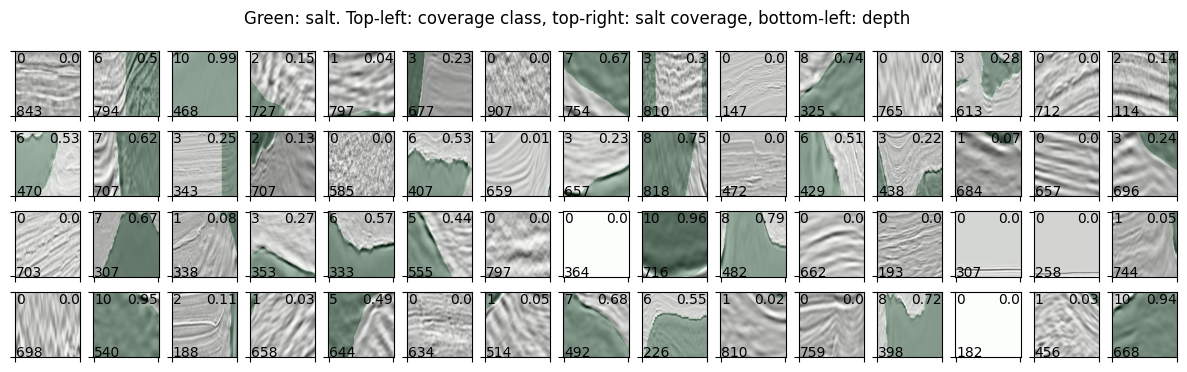

In [67]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Train/validation split w/ stratification by salt coverage

In [68]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

Text(0.5, 1.0, 'Scaled image')

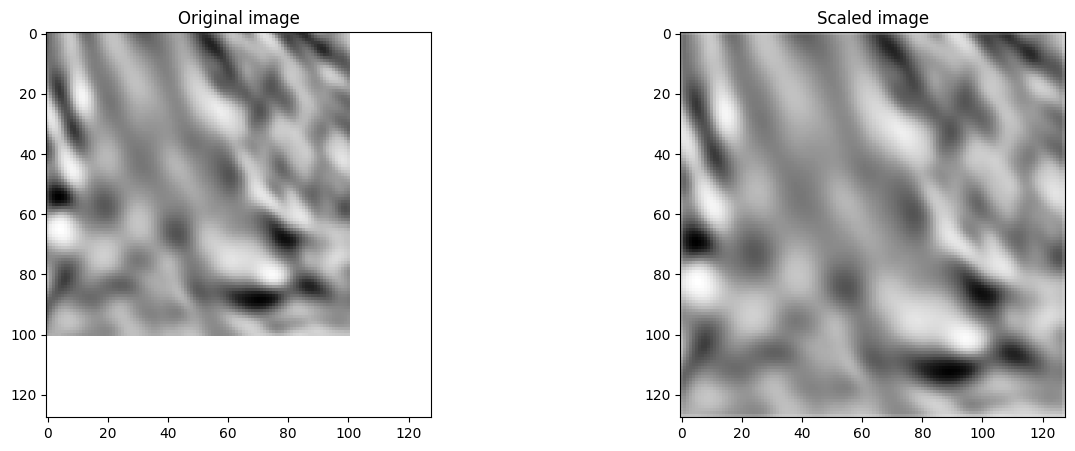

In [69]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

# Data augmentation

> En la implementación de referencia, solo hacen mirror horizontal

Se implementa el siguiente pipeline de augmentación con Albumentations:

In [70]:
augmentations  = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.33),
    A.OneOf([
        A.Sequential([
            A.ElasticTransform(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        ], p=1.0),
        A.Sequential([
            A.RandomCrop(width=img_size_target*0.5, height=img_size_target*0.5, p=1.0),
            A.Resize(128, 128, p=1.0)
        ], p=1.0),      
        A.Sequential([
            A.RandomCrop(width=img_size_target*0.75, height=img_size_target*0.75, p=1.0),
            A.Resize(128, 128, p=1.0)
        ], p=1.0),      
      ], p=1.0)
  ])

In [71]:
def aug_x_y(x, y, augs):
    augmented = augs(image=x, mask=y)
    return augmented['image'], augmented['mask']

Se muestran los efectos de las augmentaciones en distintas runs y para distintas imágenes:

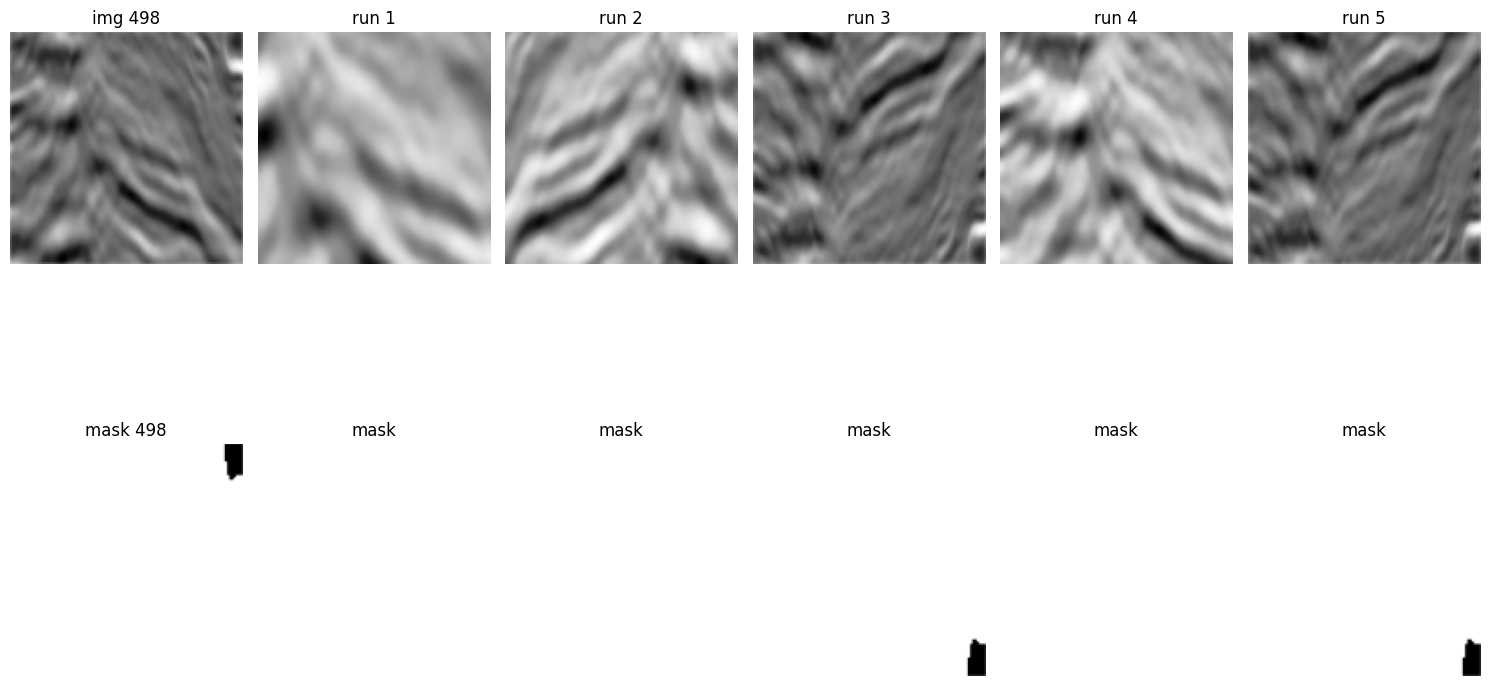

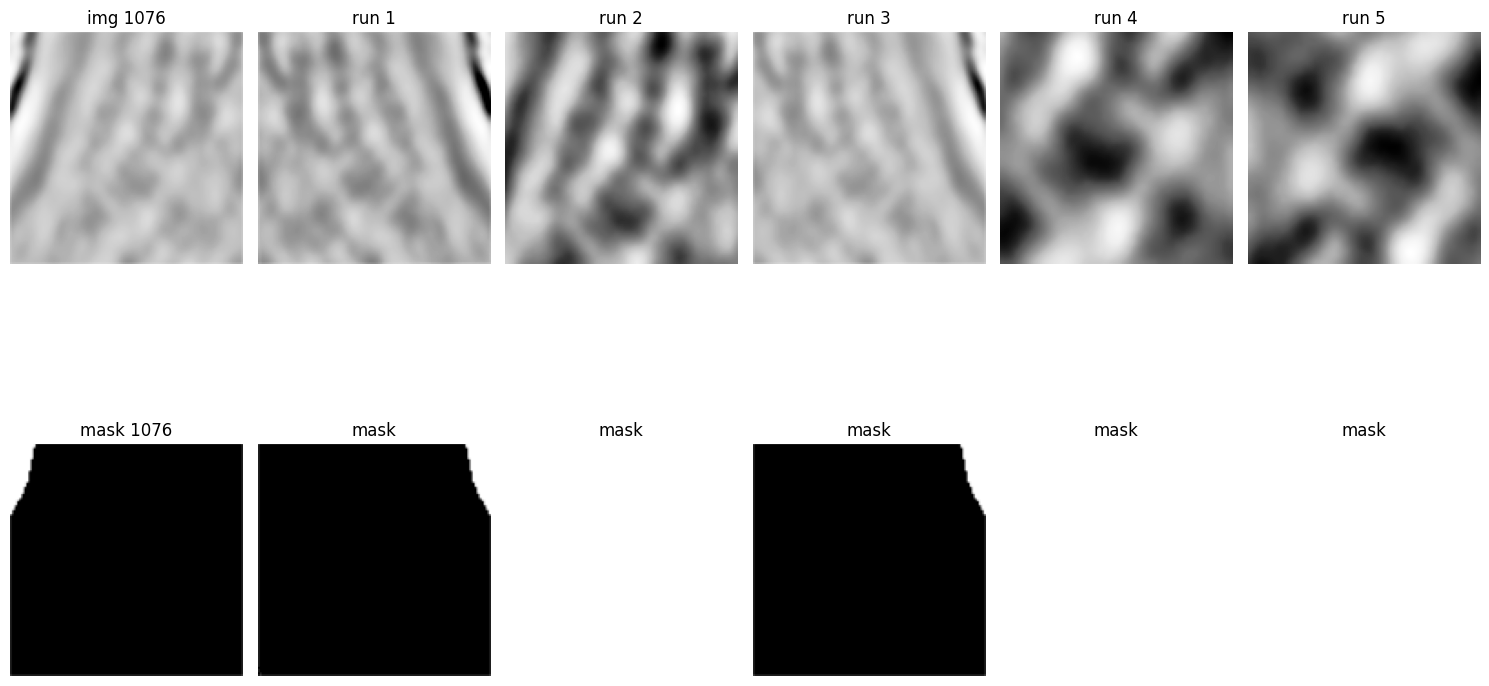

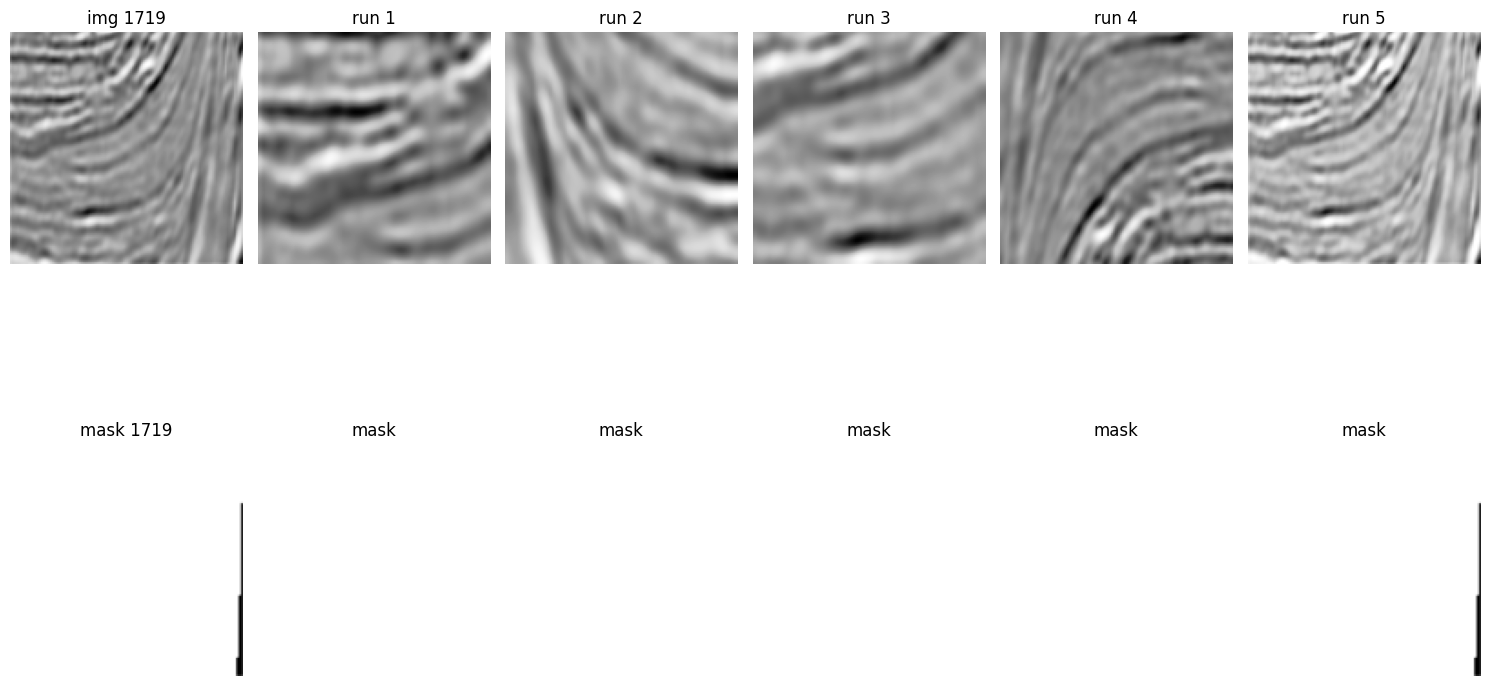

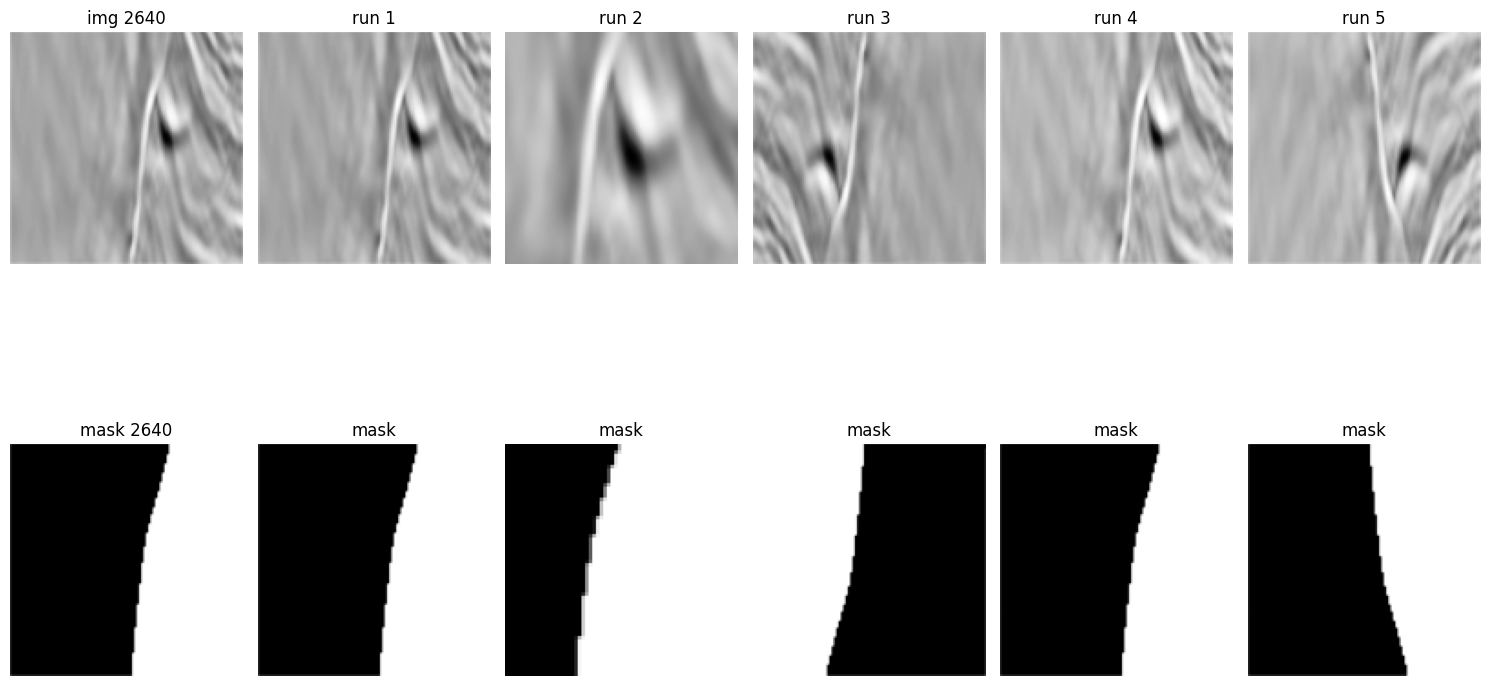

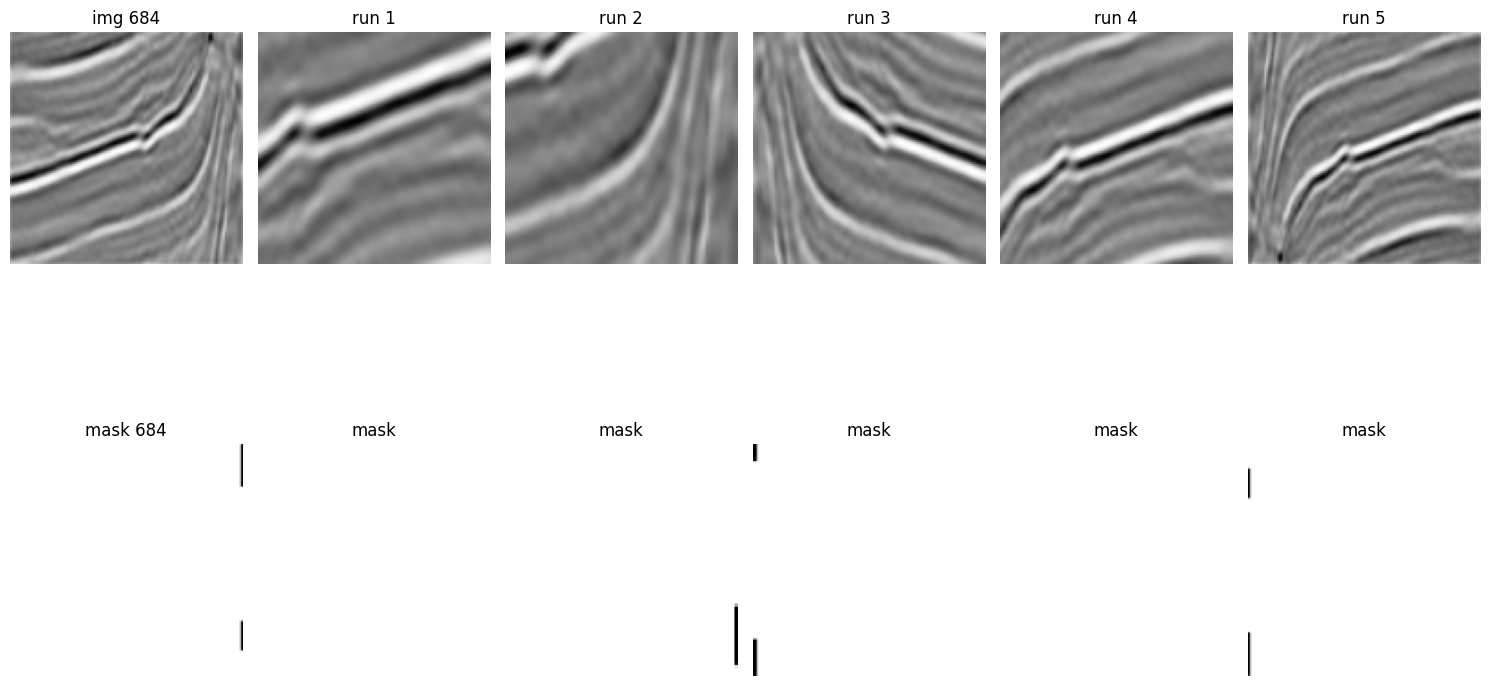

In [72]:
for u in range(0, 5):
    random_index = np.random.randint(0, len(x_train))
    x_original, y_original = x_train[random_index], y_train[random_index]
    
    fig, axes = plt.subplots(2, 6, figsize=(15, 10))
    
    axes[0, 0].imshow(x_original.squeeze(), cmap="Greys")
    axes[0, 0].axis('off')
    axes[0, 0].set_title(f"img {random_index}")
    
    axes[1, 0].imshow(y_original.squeeze(), cmap="Greys")
    axes[1, 0].axis('off')
    axes[1, 0].set_title(f"mask {random_index}")
    
    for i in range(1, 6):
        x_aug, y_aug = aug_x_y(x_original, y_original, augmentations)
    
        axes[0, i].imshow(x_aug.squeeze(), cmap="Greys")
        axes[0, i].axis('off')
        axes[0, i].set_title(f"run {i}")
    
        axes[1, i].imshow(y_aug.squeeze(), cmap="Greys")
        axes[1, i].axis('off')
        axes[1, i].set_title(f"mask")
    
    plt.tight_layout()
    plt.show() 

Se aplica la augmentación sobre train 4 veces:

In [73]:
augmentations_runs = 4
base_len = len(x_train)

for i in tqdm(range(augmentations_runs)):
    tmp_x_aug = []
    tmp_y_aug = []
    
    for j in tqdm(range(base_len)):
        x_aug, y_aug = aug_x_y(x_train[j], y_train[j], augmentations)
        tmp_x_aug.append(x_aug)
        tmp_y_aug.append(y_aug)

    tmp_x_aug = np.array(tmp_x_aug)
    tmp_y_aug = np.array(tmp_y_aug)

    x_train = np.concatenate((x_train, tmp_x_aug), axis=0)
    y_train = np.concatenate((y_train, tmp_y_aug), axis=0)

100%|██████████| 4/4 [00:15<00:00,  3.93s/it]


In [74]:
base_len, len(x_train)

(3200, 16000)

Se muestran algunos ejemplos del dataset de train augmentado:

Text(0.5, 0.98, 'Top row: original images, bottom row: augmented images')

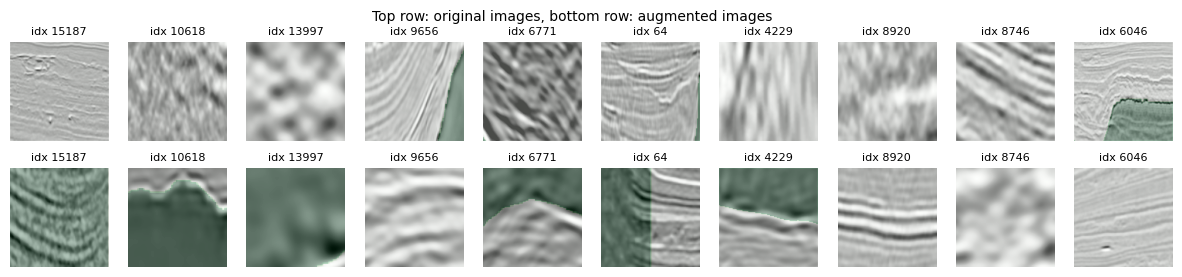

In [75]:
random_indices = np.random.choice(len(x_train), size=10, replace=False)

fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i,idx in enumerate(random_indices):
    axs[0][i].imshow(x_train[idx].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[idx].squeeze(), cmap="Greens", alpha=0.3)
    axs[0][i].set_title(f"idx {idx}", fontsize=8)
    axs[0][i].axis('off')
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].set_title(f"idx {idx}", fontsize=8)
    axs[1][i].axis('off')
fig.suptitle("Top row: original images, bottom row: augmented images", fontsize=10)

# Model, U-Net

## Build

In [97]:
# def build_model(input_layer, start_neurons):
#     # 128 -> 64
#     conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
#     conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
#     pool1 = MaxPooling2D((2, 2))(conv1)
#     pool1 = Dropout(0.25)(pool1)

#     # 64 -> 32
#     conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
#     conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
#     pool2 = MaxPooling2D((2, 2))(conv2)
#     pool2 = Dropout(0.5)(pool2)

#     # 32 -> 16
#     conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
#     conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
#     pool3 = MaxPooling2D((2, 2))(conv3)
#     pool3 = Dropout(0.5)(pool3)

#     # 16 -> 8
#     conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
#     conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
#     pool4 = MaxPooling2D((2, 2))(conv4)
#     pool4 = Dropout(0.5)(pool4)

#     # Middle
#     convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
#     convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

#     # 8 -> 16
#     deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
#     uconv4 = concatenate([deconv4, conv4])
#     uconv4 = Dropout(0.5)(uconv4)
#     uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
#     uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

#     # 16 -> 32
#     deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
#     uconv3 = concatenate([deconv3, conv3])
#     uconv3 = Dropout(0.5)(uconv3)
#     uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
#     uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

#     # 32 -> 64
#     deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
#     uconv2 = concatenate([deconv2, conv2])
#     uconv2 = Dropout(0.5)(uconv2)
#     uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
#     uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

#     # 64 -> 128
#     deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
#     uconv1 = concatenate([deconv1, conv1])
#     uconv1 = Dropout(0.5)(uconv1)
#     uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
#     uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

#     uconv1 = Dropout(0.5)(uconv1)
#     output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
#     return output_layer

# input_layer = Input((img_size_target, img_size_target, 1))
# output_layer = build_model(input_layer, 16)

def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(negative_slope=0.1)(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(negative_slope=0.1)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(negative_slope=0.1)(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(negative_slope=0.1)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(negative_slope=0.1)(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(negative_slope=0.1)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), padding="same")(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(negative_slope=0.1)(conv4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(negative_slope=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), padding="same")(pool4)
    convm = BatchNormalization()(convm)
    convm = LeakyReLU(negative_slope=0.1)(convm)
    convm = Conv2D(start_neurons * 16, (3, 3), padding="same")(convm)
    convm = BatchNormalization()(convm)
    convm = LeakyReLU(negative_slope=0.1)(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = LeakyReLU(negative_slope=0.1)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = LeakyReLU(negative_slope=0.1)(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = LeakyReLU(negative_slope=0.1)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = LeakyReLU(negative_slope=0.1)(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = LeakyReLU(negative_slope=0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = LeakyReLU(negative_slope=0.1)(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = LeakyReLU(negative_slope=0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = LeakyReLU(negative_slope=0.1)(uconv1)

    uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

## IoU custom metric

In [98]:
def custom_iou(y_true, y_pred):
    y_pred = ops.cast(y_pred > 0.5, tf.bool)
    y_true = ops.cast(y_true > 0.5, tf.bool)

    intersection = ops.sum(ops.cast(ops.logical_and(y_true, y_pred), tf.float32))
    union = ops.sum(ops.cast(ops.logical_or(y_true, y_pred), tf.float32))

    iou = intersection / ops.maximum(union, tf.keras.backend.epsilon())

    thresholds = tf.range(0.1, 1.0, 0.05)
    s = tf.map_fn(lambda t: ops.cast(iou > t, tf.float32), thresholds)

    return ops.mean(s)

## Búsqueda de HP | Train

In [99]:
configurations = [
    {"loss": BinaryCrossentropy(), "optimizer": Adam(), "metric": "accuracy"},
    {"loss": BinaryFocalCrossentropy(), "optimizer": Adam(), "metric": "accuracy"},
    {"loss": BinaryCrossentropy(), "optimizer": SGD(), "metric": "accuracy"},
    {"loss": BinaryFocalCrossentropy(), "optimizer": SGD(), "metric": "accuracy"},
    {"loss": BinaryCrossentropy(), "optimizer": Adam(), "metric": custom_iou},
    {"loss": BinaryFocalCrossentropy(), "optimizer": Adam(), "metric": custom_iou},
    {"loss": BinaryCrossentropy(), "optimizer": SGD(), "metric": custom_iou},
    {"loss": BinaryFocalCrossentropy(), "optimizer": SGD(), "metric": custom_iou},
]

In [100]:
results = []

for i, config in enumerate(configurations):
    # nombre de la métrica para monitorear en callbacks
    metric_name = "val_accuracy" if config["metric"] == "accuracy" else "val_custom_iou"
    
    print(f"\nEntrenando configuración {i+1}/{len(configurations)}:")
    print(f"Loss: {config['loss']}, Optimizer: {config['optimizer'].__class__.__name__}, Metric: {config['metric']}")

    # instancia del la U-Net
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16)
    model = Model(input_layer, output_layer)
    
    model.compile(
        loss=config["loss"],
        optimizer=config["optimizer"],
        metrics=[config["metric"]]
    )
    
    # callbacks
    early_stopping = EarlyStopping(monitor=metric_name, patience=10, restore_best_weights=True, mode='max')
    model_checkpoint = ModelCheckpoint(f"/kaggle/working/bestmodel_config_{i}.keras", 
                                        monitor=metric_name, 
                                        save_best_only=True, 
                                        mode='max')
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, factor=0.1, patience=5, min_lr=1e-6, mode='max')
    
    # train
    history = model.fit(
        x_train, y_train,
        validation_data=(x_valid, y_valid),
        epochs=100,
        batch_size=128,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
    
    # log
    best_val_metric = max(history.history[metric_name])
    results.append({"config": config, "best_val_metric": best_val_metric, "history": history.history})


Entrenando configuración 1/8:
Loss: <keras.src.losses.losses.BinaryCrossentropy object at 0x79e634ba1c90>, Optimizer: Adam, Metric: accuracy
Epoch 1/100


I0000 00:00:1732346313.159011     155 service.cc:145] XLA service 0x79e4bc001df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732346313.159074     155 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732346313.159078     155 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-23 07:19:07.434179: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,128,128]{3,2,1,0}, f32[128,16,128,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-23 07:19:08.626123: E external/local_xla

125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 396ms/step - accuracy: 0.6582 - loss: 0.5953 - val_accuracy: 0.4519 - val_loss: 2.1057 - learning_rate: 0.0010
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 357ms/step - accuracy: 0.8388 - loss: 0.4026 - val_accuracy: 0.3226 - val_loss: 1.6566 - learning_rate: 0.0010
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 364ms/step - accuracy: 0.8599 - loss: 0.3557 - val_accuracy: 0.6358 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 361ms/step - accuracy: 0.8684 - loss: 0.3313 - val_accuracy: 0.7930 - val_loss: 0.5609 - learning_rate: 0.0010
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 363ms/step - accuracy: 0.8826 - loss: 0.3001 - val_accuracy: 0.8558 - val_loss: 0.2957 - learning_rate: 0.0010
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 363ms/step - accuracy: 0.8900 - loss: 0.2813 - val_accuracy: 0.8649 - val_loss: 0.3308 - learning_rate: 0.0010
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 361ms/step - accuracy: 0.8897 

## Resultados

> Por algún motivo, las combinaciones con SGD + custom_iou hacen diverger la métrica (a cero)

In [110]:
accuracy_results = [res for res in results if res["config"]["metric"] == "accuracy"]
iou_results = [res for res in results if res["config"]["metric"] == custom_iou]

In [111]:
def display_results(sorted_results, metric_label):
    print(f"\nResultados ordenados para {metric_label}:")
    for idx, res in enumerate(sorted_results):
        config = res["config"]
        best_val_metric = res["best_val_metric"]
        history = res["history"]

        # config detail
        print(f"\nConfig {idx + 1}:")
        print(f"  Loss: {config['loss']}")
        print(f"  Optimizer: {config['optimizer'].__class__.__name__}")
        print(f"  Metric: {config['metric']}")
        print(f"  Best Metric ({metric_label}): {best_val_metric:.4f}")

        # train & val history
        train_metric_name = "accuracy" if config["metric"] == "accuracy" else "custom_iou"
        val_metric_name = "val_accuracy" if config["metric"] == "accuracy" else "val_custom_iou"

        plt.figure(figsize=(10, 6))
        plt.plot(history[train_metric_name], label=f"Train {train_metric_name}")
        plt.plot(history[val_metric_name], label=f"Validation {val_metric_name}")
        plt.title(f"Config {idx + 1}: {config['loss']}, {config['optimizer'].__class__.__name__}, {config['metric']}")
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.grid(True)
        plt.show()


Resultados ordenados para accuracy:

Config 1:
  Loss: <keras.src.losses.losses.BinaryFocalCrossentropy object at 0x79e63d290400>
  Optimizer: Adam
  Metric: accuracy
  Best Metric (accuracy): 0.9283


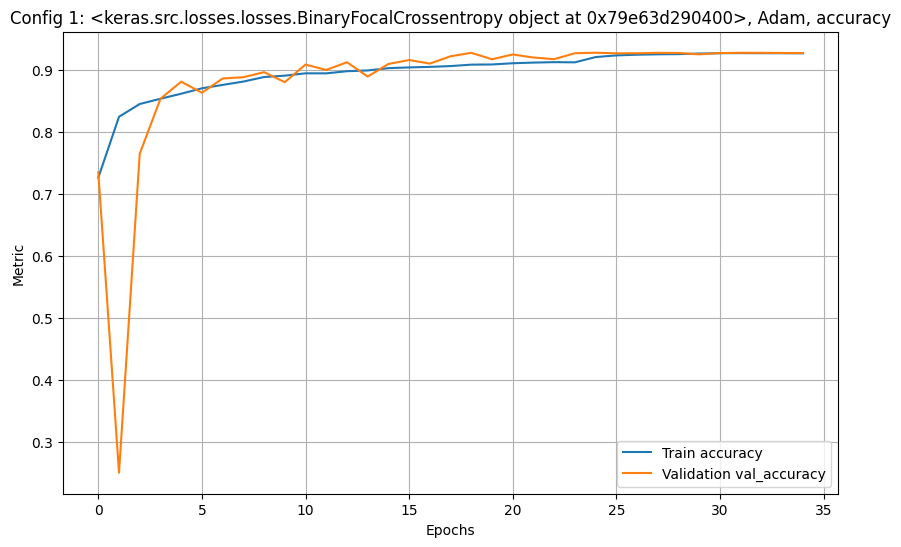


Config 2:
  Loss: <keras.src.losses.losses.BinaryCrossentropy object at 0x79e634ba1c90>
  Optimizer: Adam
  Metric: accuracy
  Best Metric (accuracy): 0.9269


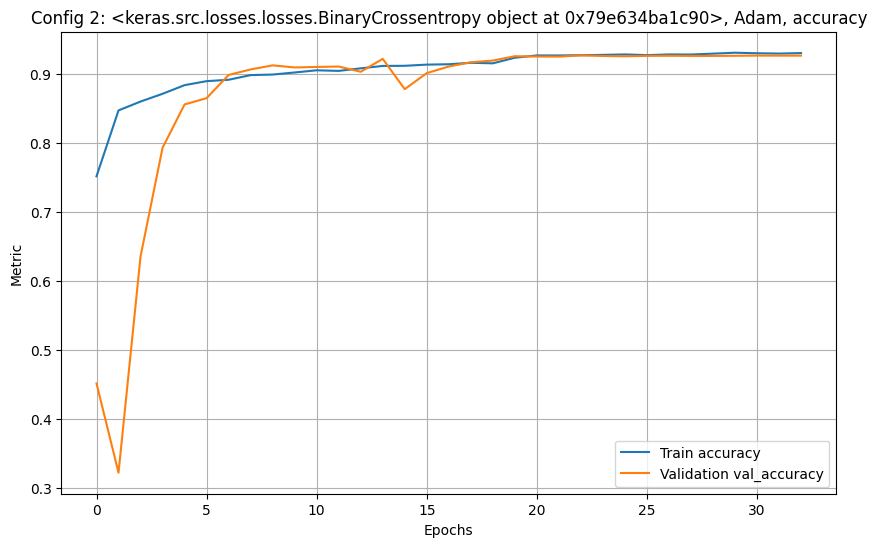


Config 3:
  Loss: <keras.src.losses.losses.BinaryCrossentropy object at 0x79e63d118f70>
  Optimizer: SGD
  Metric: accuracy
  Best Metric (accuracy): 0.8294


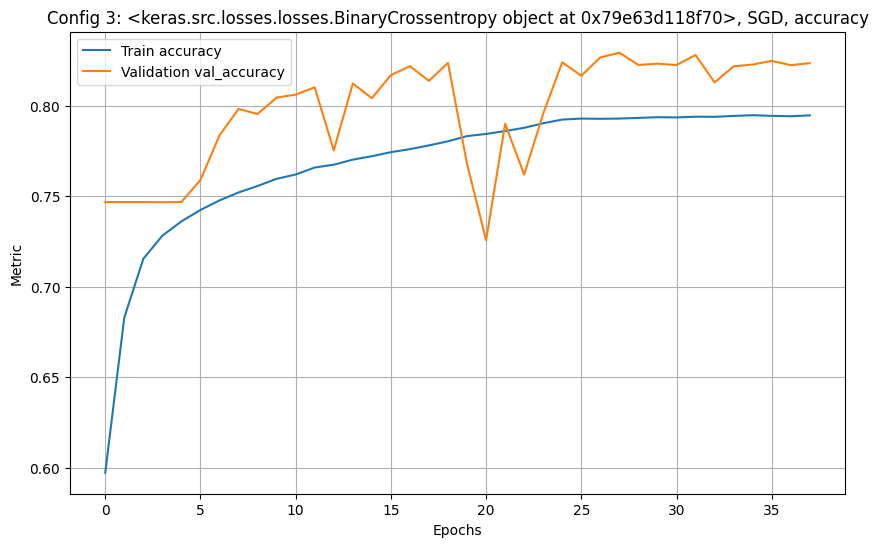


Config 4:
  Loss: <keras.src.losses.losses.BinaryFocalCrossentropy object at 0x79e63d21b550>
  Optimizer: SGD
  Metric: accuracy
  Best Metric (accuracy): 0.7468


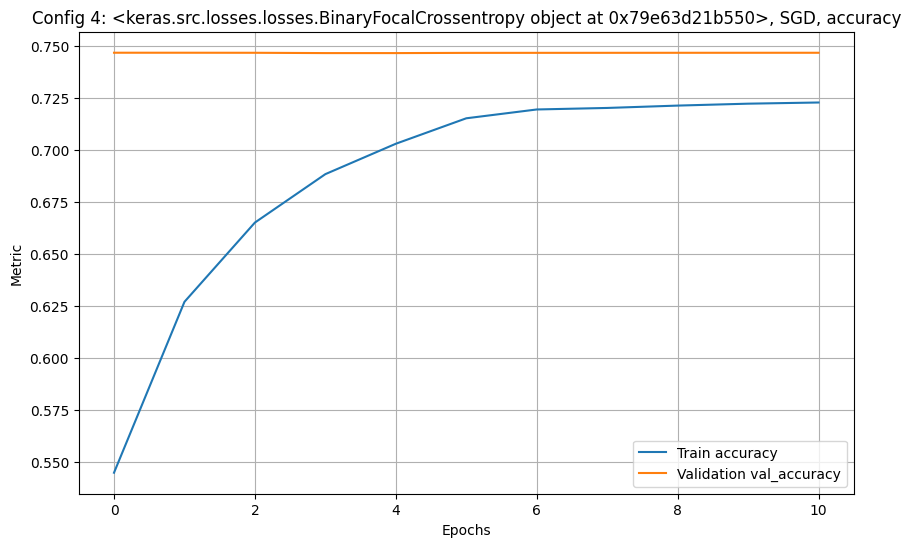


Resultados ordenados para custom_iou:

Config 1:
  Loss: <keras.src.losses.losses.BinaryFocalCrossentropy object at 0x79e63cf4a590>
  Optimizer: Adam
  Metric: <function custom_iou at 0x79e616b56200>
  Best Metric (custom_iou): 0.7619


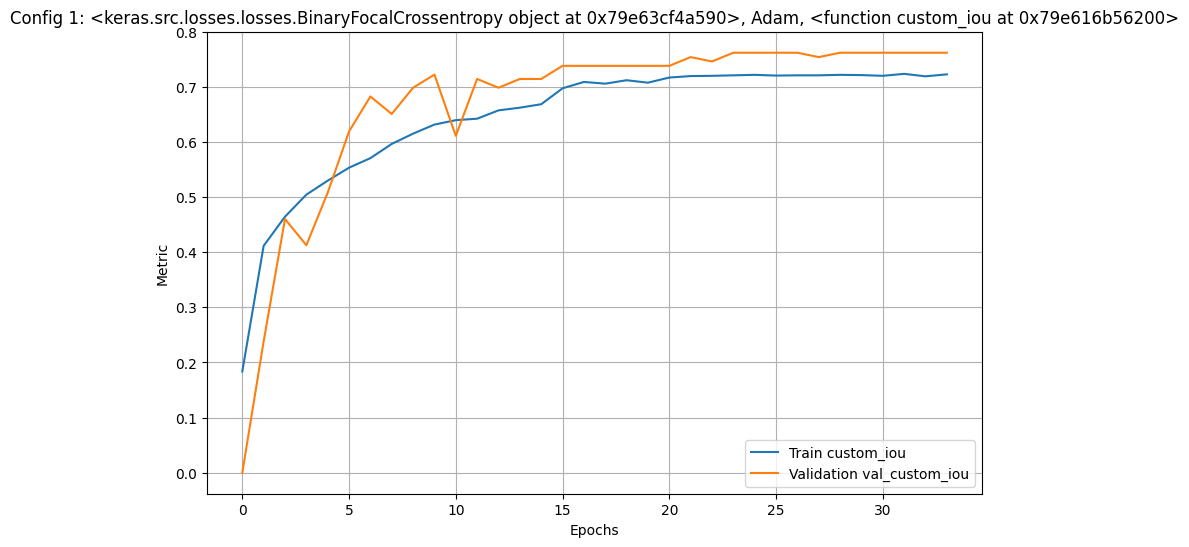


Config 2:
  Loss: <keras.src.losses.losses.BinaryCrossentropy object at 0x79e63cf4a020>
  Optimizer: Adam
  Metric: <function custom_iou at 0x79e616b56200>
  Best Metric (custom_iou): 0.7619


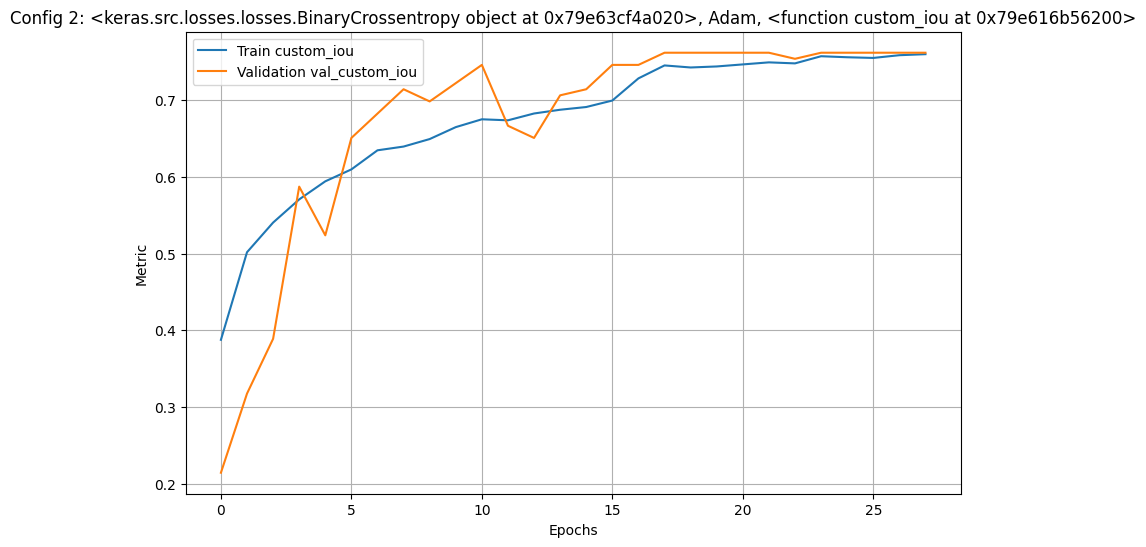


Config 3:
  Loss: <keras.src.losses.losses.BinaryFocalCrossentropy object at 0x79e634a09e70>
  Optimizer: SGD
  Metric: <function custom_iou at 0x79e616b56200>
  Best Metric (custom_iou): 0.2143


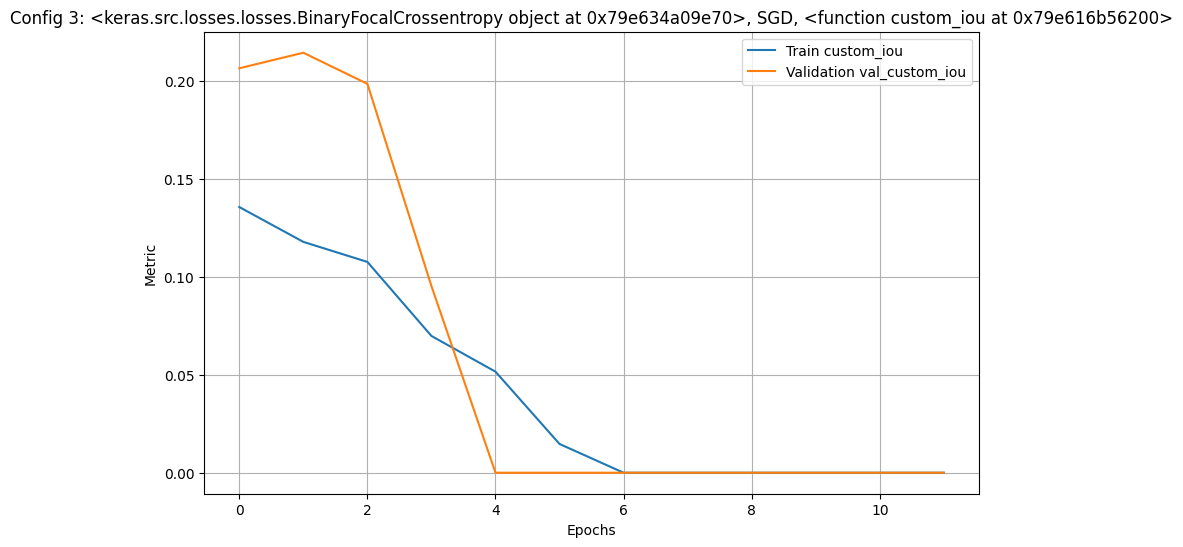


Config 4:
  Loss: <keras.src.losses.losses.BinaryCrossentropy object at 0x79e6609d9240>
  Optimizer: SGD
  Metric: <function custom_iou at 0x79e616b56200>
  Best Metric (custom_iou): 0.0000


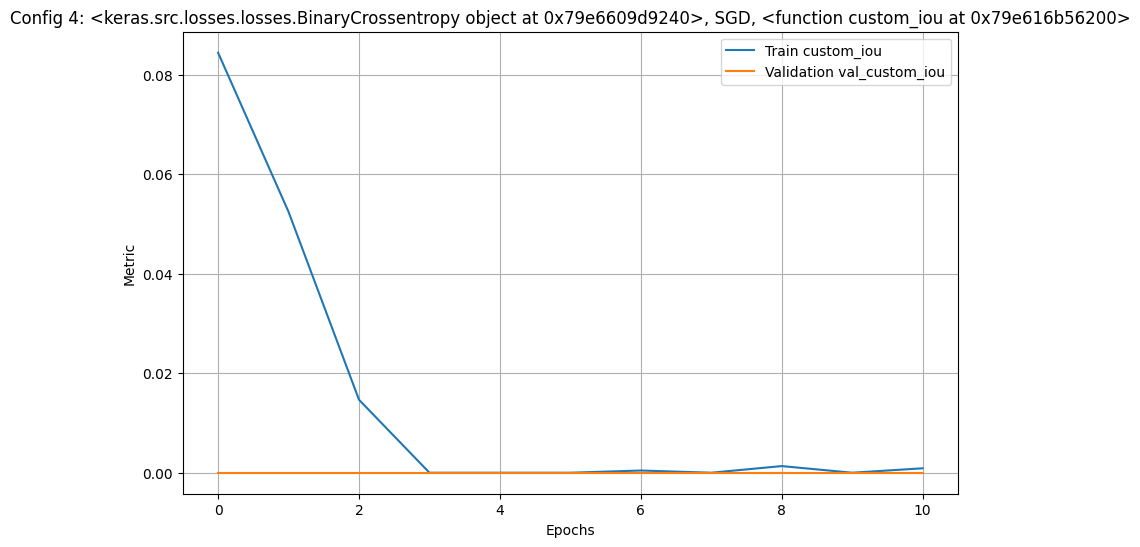

In [112]:
# sort & show results w/ accuracy metric
sorted_accuracy_results = sorted(accuracy_results, key=lambda x: x["best_val_metric"], reverse=True)
display_results(sorted_accuracy_results, "accuracy")

# sort & show results w/ IoU metric
sorted_iou_results = sorted(iou_results, key=lambda x: x["best_val_metric"], reverse=True)
display_results(sorted_iou_results, "custom_iou")

In [108]:
print(iou_results)

[]


## Carga de best model

In [113]:
model = load_model("/kaggle/working/bestmodel_config_1.keras") # best w/ accuracy
# model = load_model("/kaggle/working/bestmodel_config_5.keras") # best w/ custom_iou

# Some predict

## Raw predict over val

Se ensayan predicciones sobre el dataset de validación, para contrastar las masks verdaderas con las predichas.

In [114]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


Text(0.5, 0.98, 'Top row: original images with masks, Bottom row: predicted masks. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

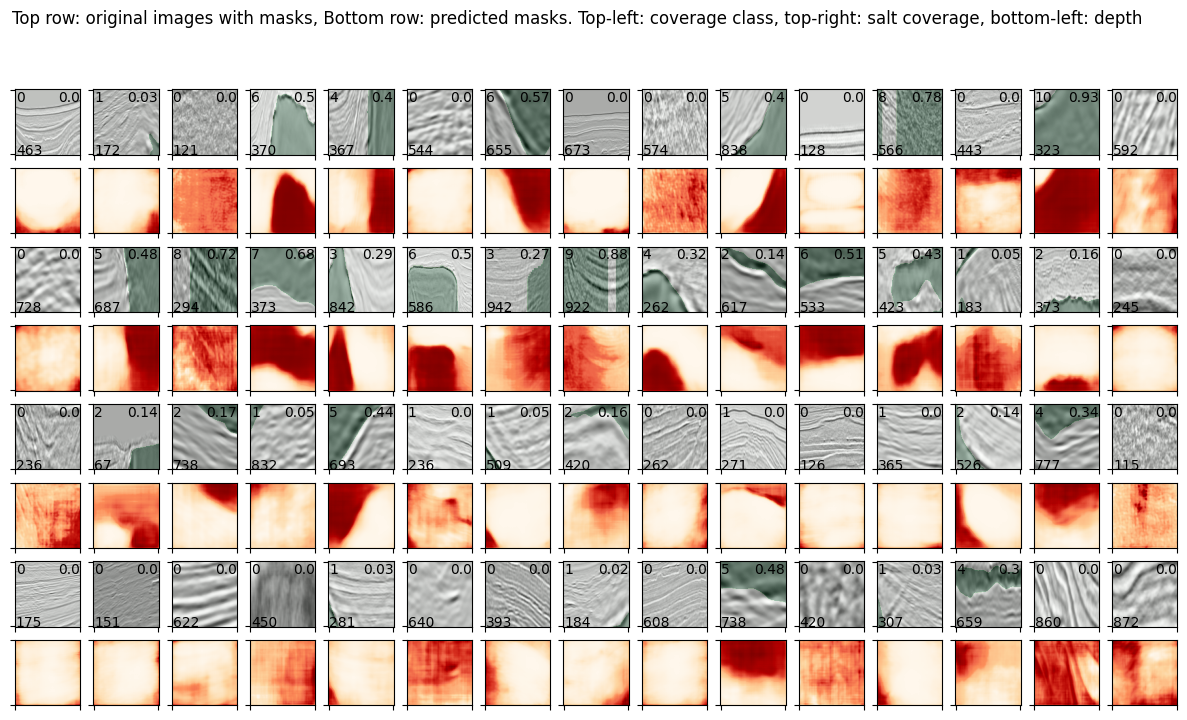

In [115]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height * 2, grid_width, figsize=(grid_width, grid_height * 2))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    
    ax_img = axs[int(i / grid_width) * 2, i % grid_width]
    ax_pred = axs[int(i / grid_width) * 2 + 1, i % grid_width]
    
    ax_img.imshow(img, cmap="Greys")
    ax_img.imshow(mask, alpha=0.3, cmap="Greens")
    ax_img.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax_img.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax_img.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax_img.set_yticklabels([])
    ax_img.set_xticklabels([])
    
    ax_pred.imshow(pred, cmap="OrRd")
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

plt.suptitle("Top row: original images with masks, Bottom row: predicted masks. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

## Raw predict over test

Se ensayan predicciones sobre el dataset de test.

In [116]:
x_test = np.array([upsample(np.array(load_img("/kaggle/working/test/images/{}.png".format(idx), color_mode='grayscale'))) / 255 for idx in tqdm(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

100%|██████████| 18000/18000 [00:25<00:00, 693.59it/s]


In [117]:
x_test_subset = x_test[0:32]

preds_test_subset = model.predict(x_test_subset).reshape(-1, img_size_target, img_size_target)
preds_test_subset = np.array([downsample(x) for x in preds_test_subset])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


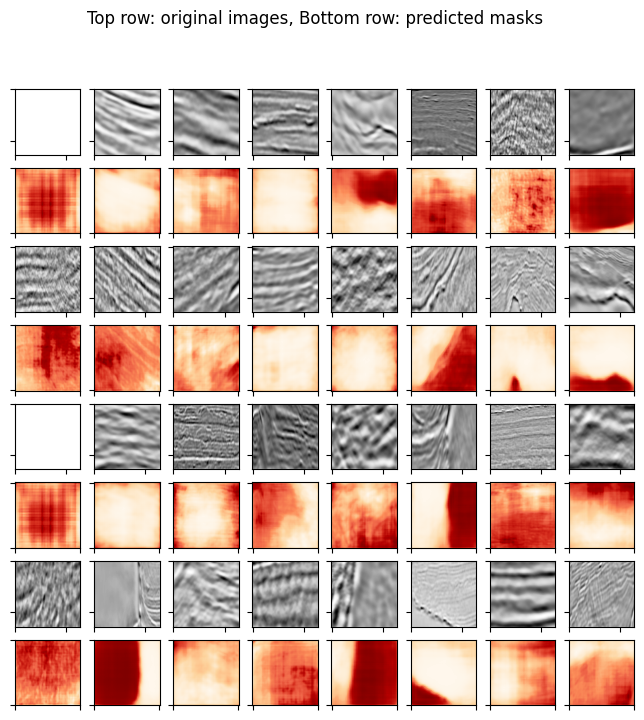

In [118]:
grid_width = 8
grid_height = int(np.ceil(len(x_test_subset) / grid_width))

fig, axs = plt.subplots(grid_height * 2, grid_width, figsize=(grid_width, grid_height * 2))

for i in range(len(x_test_subset)):
    img = x_test_subset[i].reshape(img_size_target, img_size_target)
    pred = preds_test_subset[i]
    
    ax_img = axs[int(i / grid_width) * 2, i % grid_width]
    ax_pred = axs[int(i / grid_width) * 2 + 1, i % grid_width]
    
    ax_img.imshow(img, cmap="Greys")
    ax_img.set_yticklabels([])
    ax_img.set_xticklabels([])
    
    ax_pred.imshow(pred, cmap="OrRd")
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

plt.suptitle("Top row: original images, Bottom row: predicted masks")
plt.show()

# Scoring

Se procede a calcular el score en el formato que lo pide la competencia para aplicarlo sobre las predicciones de test.

In [119]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [120]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


In [121]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

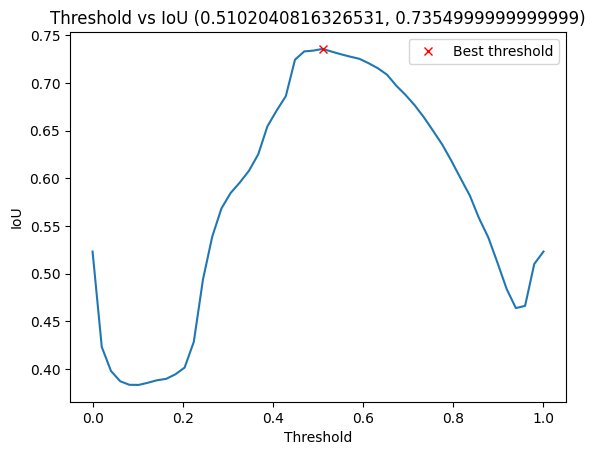

In [122]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Submission

In [123]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

Se realizan las predicciones sobre test, se calcula el escore y se exporta en el formato pedido.

In [124]:
preds_test = model.predict(x_test)

563/563 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step


In [125]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm(test_df.index.values))}

100%|██████████| 18000/18000 [05:53<00:00, 50.92it/s]


In [126]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')